In [1]:
#!/usr/bin/python
# -*- coding: utf-8 -*-

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import numpy as np

#https://github.com/mozillazg/python-pinyin
from pypinyin import pinyin, lazy_pinyin, Style

import matplotlib
import matplotlib.pyplot as plt

from nltk.translate.bleu_score import SmoothingFunction
from nltk.translate import bleu

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
def load_vocab(file_path):
    # load vocab.txt with \n at each line
    f = open(file_path,"r")
    lines = f.readlines()
    
    vocab = data_clean(lines)
    return vocab


def load_data(in_path, out_path, nb_couplets,with_all_couplets):
    couplet_in = open(in_path, "r")
    couplet_out = open(out_path, "r")

    # load original couplets
    lines_in = couplet_in.readlines()  # len = 770491
    lines_out = couplet_out.readlines()

    # clean samples
    samples_in = data_clean(lines_in)
    samples_out = data_clean(lines_out)

    # determine min and max length
    min_length = len(min(samples_in, key=len))
    max_length = len(max(samples_out, key=len))
    max_length +=  1
    print("min line length is ", min_length)
    print("max line length is ", max_length)
    # define data_in and data_out   => X and Ŷ  
    if (with_all_couplets == False):
        samples_in = samples_in[:nb_couplets]  # take some samples
        samples_out = samples_out[:nb_couplets]

    print("Loaded input couplets length is ",len(samples_in))
    print("Loaded output couplets length is ",len(samples_out))

    return samples_in, samples_out, max_length


# clean data
def data_clean(data):
    s=[]
    for i in range(0, len(data)):
        s.append(str(data[i]).replace('\n','').replace(' ','')) 
    return s


def data_clean_II(data):
    s=[]
    for i in range(0, len(data)):
        #l= str(data[i]).replace('\n','').strip('')
        l= str(data[i]).strip('\n').strip('？').strip('：').replace(' ','')
        if (l.find('，') == -1):
            s.append(l)
        else:
            l = l.split('，')
            for j in range(0, len(l)):  # seperate couplets ....................how to consider , ? !   :tjs there
                s.append(l[j])
    return s




##########

# create char2int dictionary
def create_char2int_and_int2char_dict(vocab):
    rang = np.arange(len(vocab))
    char2int_dict = dict(zip(vocab,rang))
    int2char_dict = dict(zip(rang,vocab))
    int2char_dict[0] = ''  # '' for pad
    return char2int_dict,int2char_dict


# create char2tone dictionary
def create_char2tone_dict(vocab):
    tone_dict = dict()
    tone_dict[vocab[0]]= ' '
    tone_dict[vocab[1]]= ' '
    tone_dict[vocab[2]]= ' '
    tone_dict[vocab[3]]= ' '
    for i in range(4,len(vocab)): # modify 3------------------------
        key = str(vocab[i])
        #print("key is", key)
        t = pinyin(key, style=Style.TONE3, heteronym=True)[0] # tones for the character
        #print("t is ", t)
        for j in range(len(t)):
            
            pz = str(t[j][-1])  # tone number
            #print("j",j)
            #print("pz ",pz)
            if ( pz!= (key) and pz.isdigit() ):  
                #print("-")
                if( int(pz) <= 2):
                    #print("--")
                    if (j==0):
                        #print("---")
                        tone_dict[key]=['P']
                        #print(tone_dict[key])
                    else:
                        tone_dict[key].append('P')  
                else:
                    if(j==0):
                        tone_dict[key]=['Z']
                    else:
                        tone_dict[key].append('Z')
            else: 
                if (tone_dict.get(key) == None):
                    tone_dict[key]=[' ']  # when there is no tone     # ， ？ ： 、 ； ！ - 屷 … 俬 〇 牗 -----
                
        
        tone_dict[key] = set(tone_dict[key])
        #print("tone_dict[key] set",tone_dict[key])
        tone_dict[key] = list(tone_dict[key])
        #print("tone_dict[key] list",tone_dict[key])
        res =''
        for k in range(len(tone_dict[key])):
            res += tone_dict[key][k]
        tone_dict[key] = res
    return tone_dict


    
# tokenize : couplet to int vectors
def tokenize(data, char2int_dict, max_length):  # data is sets of couplets
    v=[]
    for i in range(0, len(data)):
        l = []
        for j in range (0, len(data[i])):
            if ( char2int_dict.get(data[i][j])  is None ):
                l.append(   char2int_dict.get('UNK')  )
            else:
                l.append(   char2int_dict.get(data[i][j])  )
        if (len(data[i]) < max_length):   # padding 0(pad) at the end
            l = (l + [0] * max_length)[:max_length]
        #v.append(torch.tensor(l, dtype=torch.long, device=device).view(-1, 1))
        v.append(l)
    return v


def tokenize_dec_in(data, char2int_dict, max_length):  # data is sets of couplets
    v=[]
    for i in range(0, len(data)):
        l = [char2int_dict.get('sos')]

        for j in range (0, len(data[i])):
            if ( char2int_dict.get(data[i][j])  is None ):
                l.append(   char2int_dict.get('UNK')  )
            else:
                l.append(   char2int_dict.get(data[i][j])  )
        if (len(data[i]) < max_length):   # padding 0(pad) at the end
            l = (l + [0] * max_length)[:max_length]
        v.append(l)
        #v.append(torch.tensor(l, dtype=torch.long, device=device).view(-1, 1))
    return v


def tokenize_dec_out(data, char2int_dict, max_length):  # data is sets of couplets
    v=[]
    for i in range(0, len(data)):
        l = []
        for j in range (0, len(data[i])):
            if ( char2int_dict.get(data[i][j])  is None ):
                l.append(   char2int_dict.get('UNK')  )
            else:
                l.append(   char2int_dict.get(data[i][j])  )

        l.append(char2int_dict.get('eos'))
        if (len(data[i]) < max_length):   # padding 0(pad) at the end
            l = (l + [0] * max_length)[:max_length]
        #v.append(torch.tensor(l, dtype=torch.long, device=device).view(-1, 1))
        v.append(l)
    return v


##########

def detokenize(one_couplet, int2char_dict):
    o = ''
    for i in range(0, len(one_couplet)):
        if (one_couplet[i] >= 3):    # ignore pad,sos,eos
            o = o + int2char_dict.get(one_couplet[i].item())   # one_couplet should be like [24,576,134]
    return o
    

def detokenize_II(one_couplet, int2char_dict,n):
    o = ''
    n = min(len(one_couplet),n)
    for i in range(0, n):
        if (couplet[i] >= 3):    # ignore pad,sos,eos
            o = o + int2char_dict.get(one_couplet[i].item())  

    return o
    
def detokenize_All(couplets, int2char_dict):
    o = ''
    for i in range(0, len(couplets)):
        for j in range(len(couplets[i])):
            if (couplets[i][j] >= 3):    # ignore pad,sos,eos
                o = o + int2char_dict.get(couplets[i][j].item()) 
        o = o +"\n"
    return o



# create a dictionary of repeted words
def dict_repet_idx(one_tensor,length):
    records_array = np.array(one_tensor)[:length]
    vals, inverse, count = np.unique(records_array, return_inverse=True,return_counts=True)
    idx_vals_repeated = np.where(count > 1)[0]
    vals_repeated = vals[idx_vals_repeated]

    rows, cols = np.where(inverse == idx_vals_repeated[:, np.newaxis])
    _, inverse_rows = np.unique(rows, return_index=True)
    res = np.split(cols, inverse_rows[1:])
    
    d = dict()
    for i in range(len(res)):
        for l in range(1,len(res[i])):
            val = res[i][0]
            d[ res[i][l] ]  = val
    
    return d


# save locally
def write_to(path,words):
    f = open(path,"w")
    f.write(words)
    f.write('\n')
    f.close

In [3]:
##########################
#####humain start#########
##########################

In [12]:
def prepare_data(in_path,out_path,with_all_couplets=True):
    batch_size = 1 # ------------
    nb_couplets = 1024
    
    print("### data preparing ### ")
    print("Batch size is: ",batch_size)
    print("Use all couplets to train: ",with_all_couplets)
    if (with_all_couplets==False):
        print("\tTherefore nb_couplets to train is: ",nb_couplets)

    print("### data loading ### ")
    vocab_path = "./vocab_total_ori.txt"
    data_in, data_out, max_length = load_data(in_path,out_path,nb_couplets,with_all_couplets)
    vocab = load_vocab(vocab_path)
    vocab_size = len(vocab)
    print("Vocab length is ", vocab_size)
    return data_in,data_out,vocab,max_length

def create_dicts(data_in,data_out,vocab,max_length):

    # create char2int and int2char_dict
    char2int_dict, int2char_dict = create_char2int_and_int2char_dict(vocab)
    
    char2tone_dict = create_char2tone_dict(vocab)
    
    int2tone_dict = dict()
    for i in range(len(vocab)):
        t = char2tone_dict.get(vocab[i])
        int2tone_dict[i] = t

    return char2int_dict, int2char_dict, char2tone_dict, int2tone_dict
        
        
def create_tone_mask(vocab, char2tone_dict):
    tone_onlyP_2 = np.ones(len(vocab))
    tone_onlyZ_2 = np.ones(len(vocab))
    for i in range(len(vocab)):
        # i  <=> char_id   
        tone = char2tone_dict.get(vocab[i])
        if (tone.isalpha()):
            if (len(tone) != 2):
                if(tone == 'P'):
                    tone_onlyP_2[i] = 92233720368547758
                else:
                    tone_onlyZ_2[i] = 92233720368547758
    return tone_onlyP_2, tone_onlyZ_2

def tokenization(data_in,data_out,char2int_dict,max_length):
    # Line One from character to int
    Enc_in =  tokenize(data_in,char2int_dict,max_length)
    # Line two from character to int, with SOS and EOS
    token_out =tokenize(data_out,char2int_dict,max_length)
    Dec_in = tokenize_dec_in(data_out,char2int_dict,max_length)
    Dec_out = tokenize_dec_out(data_out,char2int_dict,max_length)  
    
    return  Enc_in,Dec_in,Dec_out

def prepare_batches(Enc_in,Dec_out,Dec_in,batch_size=1):
    in_ = []
    for i in range(0,int(len(Enc_in)/batch_size)):
        in_.append( torch.Tensor(Enc_in[batch_size*i:batch_size*(i+1)]).to(torch.int64) )
    out_ = []
    for i in range(0,int(len(Dec_out)/batch_size)):
        out_.append( torch.Tensor(Dec_out[batch_size*i:batch_size*(i+1)]).to(torch.int64) )
    dec_in_ =[]
    for i in range(0,int(len(Dec_in)/batch_size)):
        dec_in_.append( torch.Tensor(Dec_in[batch_size*i:batch_size*(i+1)]).to(torch.int64) )
    batch_in_out_pairs =[]   # may ignore some last couplets
    for i in range(0, len(in_)):
        batch_in_out_pairs.append((in_[i],dec_in_[i], out_[i]))
    print("Number of couplet batches :",len(batch_in_out_pairs))
    
    return batch_in_out_pairs


from copy import deepcopy

class Node:
    def __init__(self,indices,acc,hid,attn):
        self.indices = indices
        self.acc = acc
        self.hid = hid
        self.attn = attn

        
    def add_vi(self,val_,idx_,hid,attn):
        self.indices.append(idx_)
        self.acc = val_
        self.hid.append(hid)
        self.attn.append(attn)
    
        
    
    def printf(self):
        print("=> In Node:")
        print("=> Acc is: ",float(self.acc))
        print("=> Indices are:", [i for i in self.indices])

def detokenize_All(couplets, int2char_dict):
    o = ''
    for i in range(0, len(couplets)):
        for j in range(len(couplets[i])):
            if (couplets[i][j] >= 3):    # ignore pad,sos,eos
                o = o + int2char_dict.get(couplets[i][j].item()) 
        #o = o +"\n"
    return o

def detokenize_int(one_couplet, int2char_dict):
    o = ''
    for i in range(0, len(one_couplet)):
        if(int2char_dict.get(one_couplet[i]) is not None):
            o = o + int2char_dict.get(one_couplet[i])   # one_couplet should be like [24,576,134]
        else:
            print("what")
    return o


# create a dictionary of repeted words
def dict_repet_idx(one_tensor,length):
    records_array = np.array(one_tensor)[:length]
    vals, inverse, count = np.unique(records_array, return_inverse=True,return_counts=True)
    idx_vals_repeated = np.where(count > 1)[0]
    vals_repeated = vals[idx_vals_repeated]

    rows, cols = np.where(inverse == idx_vals_repeated[:, np.newaxis])
    _, inverse_rows = np.unique(rows, return_index=True)
    res = np.split(cols, inverse_rows[1:])
    
    d = dict()
    for i in range(len(res)):
        for l in range(1,len(res[i])):
            val = res[i][0]
            d[ res[i][l] ]  = val
    
    return d



def detokenize_int_repet(input_tensor, one_couplet, int2char_dict):
    o = ''
    longueur = np.where(np.array(input_tensor[0]) == 0)[0][0]
    d = dict_repet_idx(input_tensor[0],longueur)
    #print("Input length is ",longueur)
    
    for i in range(0, len(one_couplet)):
        idx = d.get(i)
        if ( idx is not None ):
            # use the first appreared word
            o = o + int2char_dict.get(one_couplet[idx])
        else:
            o = o + int2char_dict.get(one_couplet[i])
    return o

def model_in(i,j):
    l=[]
    l.append(Enc_in[i])
    #l.append(Enc_in[i])
    #l.append(Enc_in[j])
    #l.append(Enc_in[j])
    #l.append(Enc_in[j])
    l = torch.Tensor(l).to(torch.int64)
    q=[]
    q.append(Dec_in[i])
    #q.append(Dec_in[i])
    #q.append(Dec_in[j])
    #q.append(Dec_in[j])
    #q.append(Dec_in[j])
    q = torch.Tensor(q).to(torch.int64)
    return l,q


### evaluate one couplet
def evaluate(char2tone_dict,encoder, decoder,input_tensor,forced_tone=True,forced_word=True, beam_width=1, max_length=33):
    
    batch_size = input_tensor.size(0)
    target_length = input_tensor.size(1)
    
    encoder.eval()
    decoder.eval()
    
    longueur = [np.where(np.array(input_tensor[0]) == 0)[0][0]]
    with torch.no_grad():
        encoder_hidden = torch.zeros(2, batch_size, hidden_size)
        encoder_outputs, encoder_hidden = encoder(input_tensor, encoder_hidden,longueur)
        decoder_input = torch.tensor([1])
        decoder_hidden = encoder_hidden
        decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input.to(device), decoder_hidden.to(device), encoder_outputs.to(device))
        
        if(forced_tone):
            tone = int2tone_dict.get(int(input_tensor[0][0]))
            if( tone is not None and tone.isalpha() and len(tone) != 2 ):

                if (tone == 'P'):
                    decoder_output = decoder_output*torch.Tensor(tone_onlyP_2)
                else:
                    decoder_output = decoder_output*torch.Tensor(tone_onlyZ_2)        
        
        
        topv, topi = decoder_output.squeeze(1).topk(beam_width)
        
        decoder_input = topi.detach().t() # t() for convenience dec_in shape
        
        list_nodes = []
        init_node = Node( [], 0,[],[])  # indices,acc,hid,attn
        for l in range(0,beam_width):
            node = deepcopy(init_node)
            node.add_vi(topv[0][l],int(topi[0][l]),decoder_hidden,decoder_attention)
            list_nodes.append(node)  

        for j in range (1,longueur[0]):
            temp_val = []
            temp_idx = []
            temp_hid = []
            temp_attn = []
            for b in range(beam_width):
                decoder_output, decoder_hidden, decoder_attention = decoder(torch.tensor([ list_nodes[b].indices[-1] ]), list_nodes[b].hid[-1], encoder_outputs)
                
                if(forced_tone):
                    tone = int2tone_dict.get(int(input_tensor[0][j]))
                    if( tone is not None and tone.isalpha() and len(tone) != 2 ):

                        if (tone == 'P'):
                            decoder_output = decoder_output*torch.Tensor(tone_onlyP_2)  
                        else:
                            decoder_output = decoder_output*torch.Tensor(tone_onlyZ_2) 
                            
                
                topv, topi = decoder_output.squeeze(1).topk(beam_width)
                
                temp_val.append(topv) 
                temp_idx.append(topi)
                temp_hid.append(decoder_hidden)
                temp_attn.append(decoder_attention)
                
            for bb in range(beam_width):
                temp_val[bb] += list_nodes[bb].acc 
            
            concat = temp_val[0]
            concat_idx = temp_idx[0]
            concat_hid = []
            concat_hid.append(temp_hid[0])
            concat_attn = []
            concat_attn.append(temp_attn[0])
            for bbb in range(1,beam_width):
                concat = torch.cat((concat,temp_val[bbb]),dim=1)
                concat_idx = torch.cat((concat_idx,temp_idx[bbb]),dim=1)
                concat_hid.append(temp_hid[bbb])
                concat_attn.append(temp_attn[bbb])
            concat = concat.squeeze()
            concat_idx = concat_idx.squeeze()
            if(beam_width == 1):
                concat = concat.unsqueeze(0)
                concat_idx = concat_idx.unsqueeze(0)

            tv, ti = concat.topk(beam_width)

            new_list_nodes = []
            for bbbb in range(beam_width):
                quel_node =  int(int(ti[bbbb]) / beam_width)
                corr_nodes = list_nodes[quel_node] 

                new = deepcopy(corr_nodes)
                new.add_vi(concat[ti[bbbb]], int(concat_idx[ti[bbbb]]),concat_hid[quel_node],concat_attn[quel_node] )

                new_list_nodes.append(deepcopy(new))

            new_dec_in = []
            for e in range(len(new_list_nodes)):
                nn = new_list_nodes[e]
                new_dec_in.append(nn.indices[-1])
            new_dec_in = torch.tensor(new_dec_in).unsqueeze(1)
            
            list_nodes = deepcopy(new_list_nodes)
            decoder_input = new_dec_in

        decoded_words=[]
        for kk in range(len(list_nodes)):
            nnn = list_nodes[kk]
            d = nnn.indices
            
            if (forced_word):
                decoded_words.append( detokenize_int_repet(input_tensor, d, int2char_dict) )
            else:
                decoded_words.append( detokenize_int(d, int2char_dict) )
    return decoded_words, list_nodes
            
# evaluate randomly n couplets
def evaluateRandomly(char2tone_dict,encoder, decoder,forced_tone=True,forced_word=False,beam_width=1, n=1):

    for i in range(n):
        
        i = np.random.randint(len(Enc_in))
        
        j = np.random.randint(len(Enc_in))
        pair, d_out = model_in(i,j)
        output_words, list_nodes = evaluate(char2tone_dict,encoder, decoder, pair,forced_tone,forced_word,beam_width)
        output_words_line = '\n'.join(output_words)
        
        print("in: ")
        inn = detokenize_All(pair, int2char_dict)
        print(inn)
        print('model answer: ')
        print(output_words_line)
        print("desired answer: ")
        outt = detokenize_All(d_out, int2char_dict)
        print(outt)
        print("\n")
        
        
        # If you want to plot the attention
        # Decomment the following code
        #"""""
        attn = []
        for w in range(len(list_nodes)):
            #print("w is ",w)
            a = list_nodes[w].attn
            #print("len attn",len(a))
            attn_tmp = torch.tensor(())
            for m in range(len(a)):
                b = torch.tensor(a[m][0])
                #plt.subplots(figsize=(5, 9))
                #plt.imshow(b,cmap='hot')
                #plt.show()
                attn_tmp = torch.cat((attn_tmp, b),0) 
                
            #showAttention(pair, output_words[k], list_nodes[k].attn)
            #print("tmp shape",attn_tmp.shape)  # for j in longueur or max_length
            
            plt.subplots(figsize=(3, 2))
            #plt.imshow(attn_tmp[:8,:8],cmap='hot')
            plt.imshow(attn_tmp,cmap='hot')

            plt.colorbar()
            plt.show()
            attn.append(attn_tmp)
        #"""""
    
### bleu and attn ###
def compute_bleu(char2tone_dict,encoder, decoder,forced_tone=False,forced_word=False,beam_width=1, n=1):
    total_bleu = 0
    count=0
    #for i in range(len(batch_in_out_pairs_eval)):
    for i in range(n):#len(batch_in_out_pairs_eval)):
        
        if ( i % int(0.1*n) == 0):
            print( i / n)
        #print("idx is ",i)
        
        j = np.random.randint(len(Enc_in))
        pair, d_out = model_in(i,j)
        output_words, list_nodes = evaluate(char2tone_dict,encoder, decoder, pair,forced_tone,forced_word,beam_width)
        output_words_line = '\n'.join(output_words)
        inn = detokenize_All(pair, int2char_dict)
        outt = detokenize_All(d_out, int2char_dict)
       
        for k in range(len(output_words)):
            smoothie = SmoothingFunction().method4
            if( len(outt) == 1 and outt==output_words[k]):  # otherwise division 0
                total_bleu += 1.0
                count+=1
            else:
                b = bleu([outt], output_words[k], smoothing_function=smoothie)
                total_bleu += b
                if(b >= 0.2):
                    count+=1
                    
    print("## FIN ##")
    print("BLEU :",total_bleu/ (n*beam_width)  )
    print("#count >0.2 :",count/beam_width)        
        
# need data_in, data_out, Enc_in Dec_out
def for_humain_eval(i,n,pt,char2tone_dict,indices,om,forced_tone=True,forced_word=False,beam_width=1):
    encoder = torch.load("./models/II_enc_epoch_"+pt+".pt",map_location='cpu')
    attn_decoder = torch.load("./models/II_dec_epoch_"+pt+".pt",map_location='cpu')
    encoder.eval()
    attn_decoder.eval()
    print("encoder.hidden_size:",encoder.hidden_size)
    print("attn_decoder.hidden_size:",attn_decoder.hidden_size)

    f = open("./random_"+str(i)+"_"+pt+"_"+str(forced_tone)+"_"+str(forced_word)+"_"+str(beam_width)+".txt","w")
    f_oomm = open("./random_oomm_"+str(i)+"_"+pt+"_"+str(forced_tone)+"_"+str(forced_word)+"_"+str(beam_width)+".txt","w")
    f_a = open("./random_notes_"+str(i)+"_"+pt+"_"+str(forced_tone)+"_"+str(forced_word)+"_"+str(beam_width)+".txt","w")
    
    
    f_a.write("### oo => 0, mm => 1 ###")
    f_a.write("\n")
    
    for idx in range(n):
        
        f_a.write("-Question-"+str(idx+1)+"\n")
        f_a.write("Indices:"+str(indices[idx])+"\n")
        f_a.write("Truth:"+str(om[idx])+"\n")
        f_a.write("\n")
    
        # generate model answer
        i = indices[idx]
        pair = torch.Tensor(Enc_in[i]).to(torch.int64).unsqueeze(0)
        d_out = torch.Tensor(Dec_in[i]).to(torch.int64).unsqueeze(0)
        output_words, _ = evaluate(char2tone_dict,encoder, attn_decoder, pair,forced_tone,forced_word,beam_width)
        
        # without oomm 
        f.write("-Question-"+str(idx+1)+"\n")
        f.write("Indices:"+str(i)+"\n")
        f.write(data_in[i]+" ii\n")
        if(om[idx] == 0):
            f.write(data_out[i]+"\n")
            f.write(output_words[0]+"\n")
        else:
            f.write(output_words[0]+"\n")
            f.write(data_out[i]+"\n")
        f.write('\n')
        
        # with oomm    
        f_oomm.write("-Question-"+str(idx+1)+"\n")
        f_oomm.write("Indices:"+str(i)+"\n")
        f_oomm.write(data_in[i]+" ii\n")   
        if(om[idx] == 0): 
            f_oomm.write(data_out[i]+" oo\n")
            f_oomm.write(output_words[0]+" mm\n")
        else:
            f_oomm.write(output_words[0]+" mm\n")
            f_oomm.write(data_out[i]+" oo\n")            
        f_oomm.write('\n')
        
    f_a.close
    f.close
    f_oomm.close

In [5]:
in_path = "./test_in_remov.txt"
out_path = "./test_out_remov.txt"

In [6]:
hidden_size = 256
data_in,data_out,vocab,max_length = prepare_data(in_path,out_path,with_all_couplets=True)
char2int_dict, int2char_dict, char2tone_dict, int2tone_dict = create_dicts(data_in,data_out,vocab,max_length)
tone_onlyP_2, tone_onlyZ_2 = create_tone_mask(vocab, char2tone_dict)
Enc_in,Dec_in,Dec_out = tokenization(data_in,data_out,char2int_dict,max_length)
batch_in_out_pairs_eval = prepare_batches(Enc_in,Dec_out,Dec_in,batch_size=1)

### data preparing ### 
Batch size is:  1
Use all couplets to train:  True
### data loading ### 
min line length is  1
max line length is  32
Loaded input couplets length is  3931
Loaded output couplets length is  3931
Vocab length is  9131
Number of couplet batches : 3931


In [9]:
n=50

In [11]:
for i in range(10,20):
    indices = np.random.choice(len(Enc_in), n, replace = False)
    om = np.random.choice(2, n, replace = True)
    for_humain_eval(i,n,"203",char2tone_dict,indices,om,forced_tone=True,forced_word=True,beam_width=3)

encoder.hidden_size: 256
attn_decoder.hidden_size: 256
encoder.hidden_size: 256
attn_decoder.hidden_size: 256
encoder.hidden_size: 256
attn_decoder.hidden_size: 256
encoder.hidden_size: 256
attn_decoder.hidden_size: 256
encoder.hidden_size: 256
attn_decoder.hidden_size: 256
encoder.hidden_size: 256
attn_decoder.hidden_size: 256
encoder.hidden_size: 256
attn_decoder.hidden_size: 256
encoder.hidden_size: 256
attn_decoder.hidden_size: 256
encoder.hidden_size: 256
attn_decoder.hidden_size: 256
encoder.hidden_size: 256
attn_decoder.hidden_size: 256


In [13]:
encoder = torch.load("./models/II_enc_epoch_203.pt",map_location='cpu')
attn_decoder = torch.load("./models/II_dec_epoch_203.pt",map_location='cpu')
encoder.eval()
attn_decoder.eval()
print()

In [29]:
# evaluate randomly n couplets
def evaluateRandomly(char2tone_dict,encoder, decoder,forced_tone=True,forced_word=False,beam_width=1, n=1):
    f = open("./cou_attn.txt","a")
    for i in range(n):
        
        i = np.random.randint(len(Enc_in))
        
        j = np.random.randint(len(Enc_in))
        pair, d_out = model_in(i,j)
        output_words, list_nodes = evaluate(char2tone_dict,encoder, decoder, pair,forced_tone,forced_word,beam_width)
        output_words_line = '\n'.join(output_words)
        f.write(str(i))
        f.write("\n")
        print("in: ")
        inn = detokenize_All(pair, int2char_dict)
        print(inn)
        f.write(inn)
        f.write("\n")
        print('model answer: ')
        print(output_words_line)
        f.write(output_words_line)
        f.write("\n")
        print("desired answer: ")
        outt = detokenize_All(d_out, int2char_dict)
        print(outt)
        f.write(outt)
        f.write("\n")
        print("\n")
        
        
        # If you want to plot the attention
        # Decomment the following code
        #"""""
        attn = []
        for w in range(len(list_nodes)):
            #print("w is ",w)
            a = list_nodes[w].attn
            #print("len attn",len(a))
            attn_tmp = torch.tensor(())
            for m in range(len(a)):
                b = torch.tensor(a[m][0])
                #plt.subplots(figsize=(5, 9))
                #plt.imshow(b,cmap='hot')
                #plt.show()
                attn_tmp = torch.cat((attn_tmp, b),0) 
                
            #showAttention(pair, output_words[k], list_nodes[k].attn)
            #print("tmp shape",attn_tmp.shape)  # for j in longueur or max_length
            
            plt.subplots(figsize=(3, 2))
            #plt.imshow(attn_tmp[:8,:8],cmap='hot')
            plt.imshow(attn_tmp,cmap='hot')
            
            plt.savefig('cou_'+str(i)+'.png')

            plt.colorbar()
            plt.show()
            attn.append(attn_tmp)
        #"""""

in: 
春鸟有言率和乐
model answer: 
秋虫无语化为邻
desired answer: 
上林无树不森沉




/home/xzou/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


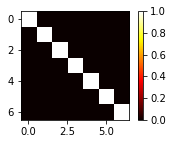

in: 
新春奉靠靠上帝
model answer: 
老少医医医医医
desired answer: 
旧年迷信信鬼神




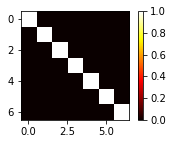

in: 
增添春色三分醉
model answer: 
换得人情一段情
desired answer: 
展现人间万里新




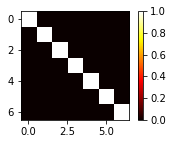

in: 
乐在其中，喜看满街，熠熠商场生紫气
model answer: 
福临世上，欣闻一笑，涓涓长坂淌清音
desired answer: 
道藏于内，只施一笑，芸芸客贾会青城




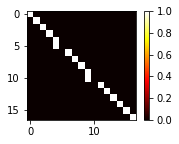

in: 
林木来时似水
model answer: 
石桥落处无尘
desired answer: 
爨烟到处如云




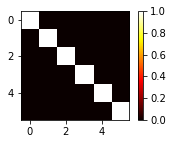

in: 
悬河风起黄天荡
model answer: 
抗日虎临赤子行
desired answer: 
大海浪回界山关




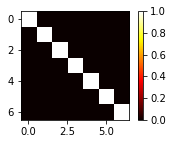

in: 
丈夫气短空呵壁
model answer: 
人世风高不染尘
desired answer: 
道士心思佛跳墙




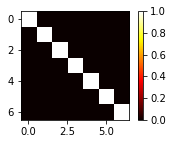

in: 
野花几点邀风赏
model answer: 
山月一池伴月眠
desired answer: 
春雨一帘惹燕啼




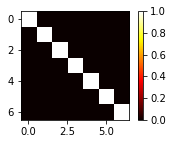

in: 
夜雨扫凉灯下影
model answer: 
秋风吹冷袖中香
desired answer: 
鸡声啼破枕边书




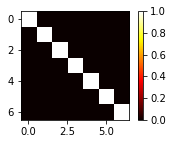

in: 
腾云驾雾冲霄汉
model answer: 
抗日震天震地球
desired answer: 
揽月摘星跃太空




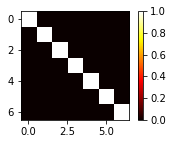

in: 
喜庆龙年击鼓忙，琼岛城乡，火树银花和鼓韵
model answer: 
欣逢盛世迎春靓，金牌市场，金城玉兔醉春风
desired answer: 
弘扬文化催征急，大江南北，山欢水笑赴征程




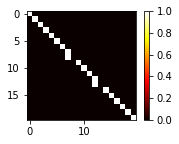

in: 
日落观风景
model answer: 
天高忆子孙
desired answer: 
炊烟起万家




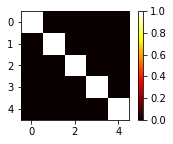

in: 
弥勒宽心，笑对人间冷暖
model answer: 
汀江大爱，轻摇月下娉婷
desired answer: 
韦驮怒目，力除世上凶邪




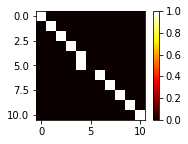

in: 
梯田翠叠，竹海波翻，水墨风情中国韵
model answer: 
宝地悠长，桃源路转，山川秀色武昌春
desired answer: 
村舍星罗，人声鼎沸，西南版本上河图




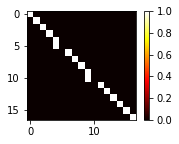

in: 
云中幸有堪归路
model answer: 
月下浑无不染尘
desired answer: 
江畔苦无可渡舟




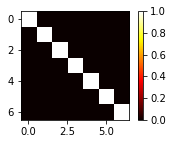

in: 
进去已非门外汉
model answer: 
归来还是梦中人
desired answer: 
出来还是庙中人




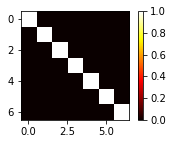

in: 
桥连曲径随林转
model answer: 
水绕闲云伴鹤归
desired answer: 
语遇直肠任口张




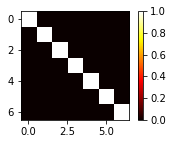

in: 
良辰逢岳降
model answer: 
瑞气蔼门临
desired answer: 
瑞气霭春晖




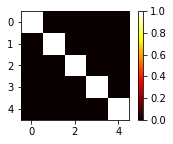

in: 
乐教梓楠同受范
model answer: 
欣看桃李自成诗
desired answer: 
喜观桃李广成材




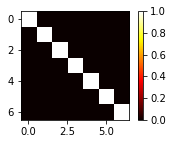

in: 
只盼来年，春醒桃红柳绿
model answer: 
常观此日，花开果满山红
desired answer: 
且迎破晓，云开月白风清




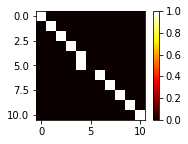

in: 
江天暮色，一晌笙歌，梦里不知身是客
model answer: 
月夜星光，千年古寺，灯前不觉梦随风
desired answer: 
烟水春花，四畴馥溢，瑶台好境蝶其谁




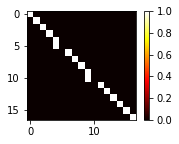

in: 
古韵迎春，雅客飞觞红袖苑
model answer: 
新区焕彩，新人醉我醉诗心
desired answer: 
盈联聚友，高朋赋对品茗轩




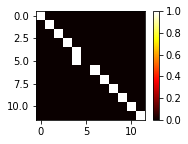

in: 
我辈复登临，地老天荒，喜此山增华阁，同时重建
model answer: 
斯人宛在在，胸怀大志，看斯世继风光，永在永恒
desired answer: 
元储饶著作，风微人往，与隔江文选楼，并寿千秋




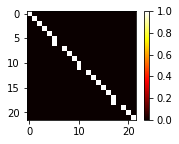

in: 
人无远虑忧多近
model answer: 
我有闲思乐有余
desired answer: 
帐有盈余庆不亏




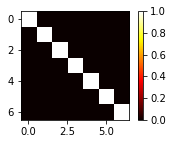

in: 
树碑立传
model answer: 
荣誉传芳
desired answer: 
添砖加瓦




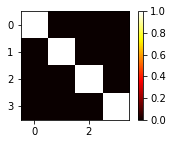

in: 
勤勉永为本
model answer: 
和谐无是根
desired answer: 
清闲自得福




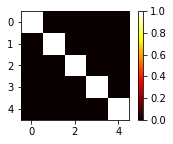

in: 
稻穗
model answer: 
葵花
desired answer: 
麻秸




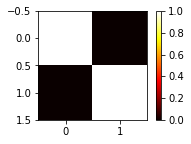

in: 
周甲庆风流，象笔鸾笺，随我歌九州日月
model answer: 
丙戌苏子夜，龙吟虎啸，与君共一统乾坤
desired answer: 
华辰添锦绣，龙骧凤翥，问谁是千古英雄




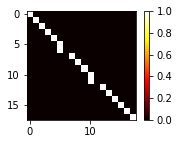

in: 
已为天上逍遥客
model answer: 
不是春风寂寞花
desired answer: 
不作人间福寿翁




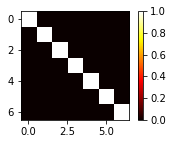

in: 
久旱逢甘雨
model answer: 
何愁见故人
desired answer: 
他乡遇故知




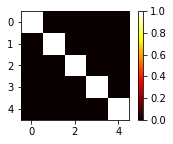

in: 
小径清幽春湿面
model answer: 
深山淡雅月明心
desired answer: 
轩窗淡雅月描眉




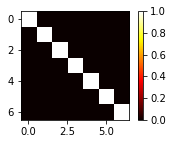

in: 
潮平岸阔，过桥即可扬帆，无限风光千里外
model answer: 
路远途遥，登顶方能揽胜，满园桃李满园中
desired answer: 
量雅心闲，世事难为顺意，有知岁月万旬时




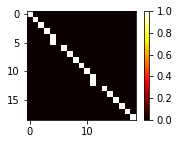

in: 
开窗风送句
model answer: 
把盏月吟诗
desired answer: 
闭帐月窥人




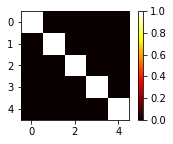

in: 
常山骄子英雄胆
model answer: 
大海盗铃盗盗心
desired answer: 
松雪道人绝妙书




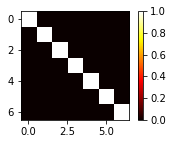

in: 
一枕残书深夜读
model answer: 
半窗明月半时圆
desired answer: 
半窗明月异乡吟




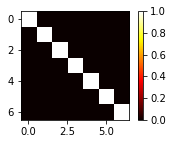

in: 
承太昊，以创中华基业
model answer: 
继炎黄，不忘祖国春秋
desired answer: 
继伏羲，而开炎夏文明




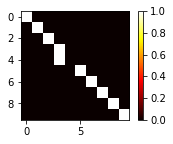

in: 
是是非非地
model answer: 
虚虚实实空
desired answer: 
明明白白天




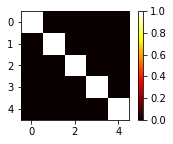

in: 
比武招亲，成双作对
model answer: 
同仇报国，抗战抗联
desired answer: 
修文展艺，夺冠排头




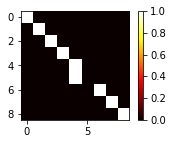

in: 
紫气蒸茶山，芽鲜叶秀
model answer: 
春风荡芦岭，粤粤春浓
desired answer: 
清泉润竹海，笋嫩篁幽




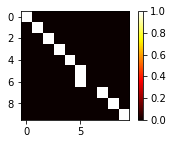

in: 
雁稀秋渐暮
model answer: 
菊烫客来秋
desired answer: 
鸦片桂永清




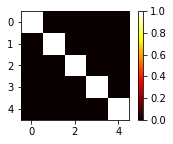

in: 
讲究操守华容道
model answer: 
协调和谐大爱心
desired answer: 
中计伏兵落凤坡




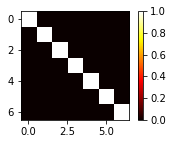

in: 
西风渐劲秋声烈
model answer: 
大雁横空雁字长
desired answer: 
大雪狂时冬意浓




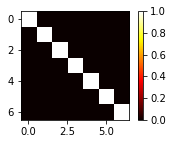

in: 
马逢伯乐常提耳
model answer: 
牛遇天时不用心
desired answer: 
牛遇田单独出头




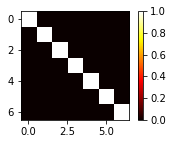

in: 
春雷似碾压山过
model answer: 
蚯蚓如犁害水行
desired answer: 
竹笋如椎破土来




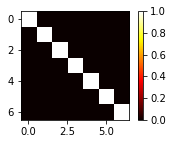

in: 
远振家风，两姓供千年俎豆
model answer: 
长传天下，三春荫一代螽斯
desired answer: 
独崇儒学，四贤师一部春秋




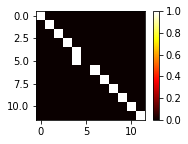

in: 
融两族，合百越，江山一统
model answer: 
启三阳，启三通，祖训千秋
desired answer: 
历八秩，献终身，华夏万年




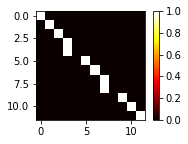

in: 
上擂观联擂
model answer: 
中书赏对书
desired answer: 
经商比智商




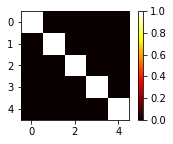

in: 
夏日池塘鸥对对
model answer: 
春风柳岸燕双双
desired answer: 
春风帘幕燕双双




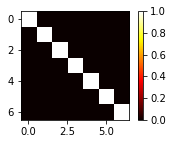

in: 
一纸清风明月句
model answer: 
几行白鹭碧云天
desired answer: 
满弦流水高山情




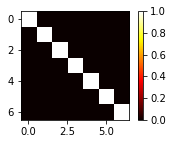

in: 
仰瞻万世威仪，喜今朝，陵墓重修，翠柏苍松益蒸蔚
model answer: 
阅阅千秋历史，看我辈，古今重振，青山碧水正光明
desired answer: 
承继千秋绪祚，看此日，河山再造，民魂国运更昌隆




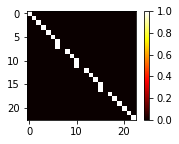

In [38]:
evaluateRandomly(char2tone_dict,encoder, attn_decoder,forced_tone=True,forced_word=True,beam_width=1,n=50)

In [20]:
# 203
compute_bleu(char2tone_dict,encoder, attn_decoder,forced_tone=True,forced_word=True,beam_width=1,n=len(batch_in_out_pairs_eval))

0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
## FIN ##
BLEU : 0.17173033244710195
#count >0.2 : 4.0


In [16]:
# 203
compute_bleu(char2tone_dict,encoder, attn_decoder,forced_tone=True,forced_word=True,beam_width=3,n=len(batch_in_out_pairs_eval))

0.0


NameError: name 'device' is not defined

In [54]:
# 203
compute_bleu(char2tone_dict,encoder, attn_decoder,forced_tone=True,forced_word=True,beam_width=5,n=len(batch_in_out_pairs_eval))

0.0
0.09997456118036123
0.19994912236072246
0.2999236835410837
0.3998982447214449
0.49987280590180616
0.5998473670821673
0.6998219282625286
0.7997964894428898
0.8997710506232511
0.9997456118036123
## FIN ##
BLEU : 0.13732333521721898
#count >0.2 : 1146.6
